# 앙상블 (Ensemble): Boosting
 - 다양한 모델을 결합하여 예측 성능을 향상시키는 방법
    - 깊이가 얕은 결정트리를 사용해 이전 트리의 오차를 보정하는 방식
    - 순차적으로 경사하강법을 사용해 이전 트리의 오차를 줄여나감
        - 분류모델에서는 손실함수 Logloss를 사용해 오차를 줄임
        - 회귀모델에서는 손실함수 MSE를 사용해 오차를 줄임
    - Boosting 계열은 일반적으로 결정트리 개수를 늘려도 과적합에 강함
    - 대표적인 알고리즘(모델): GradientBoosting, HistGradientBoosting, XGBoost(DMLC), LightGBM(MS), CatBoost

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### GradientBoosting 구현

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [21]:
class SimpleGradientBoostingClassifier : 

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initial_log_odds = 0        # 초기 예측값 
        self.trees = []                  # estimator 모음 배열 

    def log_odds(self, p):
        # 확률값 -> 로짓 변환
        return np.log(p / (1-p))

    def sigmoid(self, z):
        # z값 -> 0~1 사이의 확률 값 변환
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        y_mean = np.mean(y)
        self.initial_log_odds = self.log_odds(y_mean)
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)

        for _ in range(self.n_estimators) :
            y_pred_proba = self.sigmoid(y_pred_log_odds)
            residual = y - y_pred_proba
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)      # *** 중요 *** 이전에 학습한 모델에서의 잔차를 이용해서 학습 (y데이터 말고, 전 모델의 잔차)
            self.trees.append(tree)
            y_pred_log_odds += self.learning_rate * tree.predict(X)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)    # bool 값을 숫자로 변환

    def predict_proba(self, X):
        y_pred_log_odds = np.full((X.shape[0],), self.initial_log_odds)
        
        for tree in self.trees :
            y_pred_log_odds += self.learning_rate * tree.predict(X)    # 예측값을 누적으로 반환
        return self.sigmoid(y_pred_log_odds)

In [22]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

simple_gb_clf = SimpleGradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3
)

simple_gb_clf.fit(X_train, y_train)

y_pred_train = simple_gb_clf.predict(X_train)
y_pred_test = simple_gb_clf.predict(X_test)
print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}')
print(f'평가 정확도: {accuracy_score(y_test, y_pred_test)}')

학습 정확도: 0.9929577464788732
평가 정확도: 0.958041958041958


### 와인데이터셋 이진분류

정확도: 0.8812


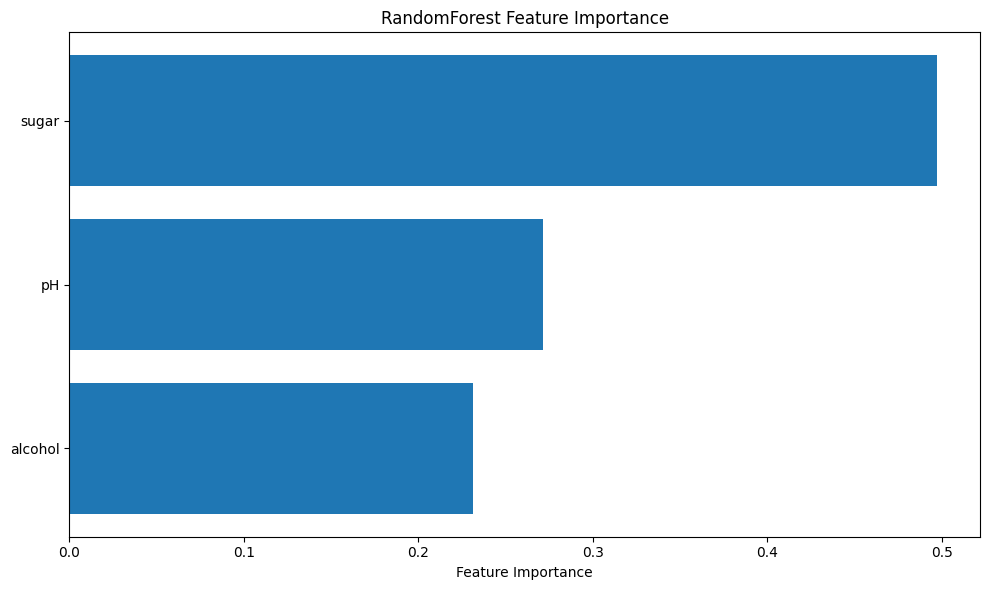

In [23]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 로드
wine_data = pd.read_csv('./data/wine_simple.csv')

# 2. 데이터 분리
X = wine_data.drop('class', axis=1)
y = wine_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. RandomForestClassifier 모델 생성 및 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# 4. 예측
y_pred = rf_clf.predict(X_test)

# 5. 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도: {accuracy:.4f}")

# 6. 특성 중요도 시각화
importances = rf_clf.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("RandomForest Feature Importance")
plt.tight_layout()
plt.show()

### 인간행동인식 다중 분류

##### [실습] 인간행동인식 다중 분류

   https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones
  
   - WALKING
   사용자 행동 target class
   - WALKING_UPSTAIRS
   - WALKING_DOWNSTAIRS
   - SITTING
   - STANDING
   - LAYING
   
   **HAR 특성 설명**

| **특성 유형**             | **설명**|
|--------------------------|------------------------------------------------------------------------------------------------------------|
| **Mean와 Std** |'tBodyAcc-mean()-X', 'tBodyAcc-std()-Y'와 같은 특성은 시간 도메인에서의 신체 가속도에 대한 평균 및 표준편차 값 ('X', 'Y', 'Z'는 축을 의미) |
| **주파수 도메인 특징**|이름에 'f'로 시작하는 특성은 주파수 도메인에서 계산된 값 (예를 들어 'fBodyAcc-meanFreq()-X'는 신체 가속도 센서의 X축에서의 평균 주파수 값)|
| **가속도와 자이로스코프 데이터** | 'tBodyAcc', 'tGravityAcc', 'tBodyGyro' 등의 특성은 신체 가속도, 중력 가속도, 자이로스코프 데이터|
| **Jerk 신호**             | 'tBodyAccJerk-mean()-X'와 같은 특성은 가속도의 변화율 (활동 간의 차이를 분류하는 데 중요한 역할)|
| **Magnitude(크기)**       | 'tBodyAccMag-mean()', 'tGravityAccMag-std()'와 같은 특성은 특정 축 방향의 가속도 또는 자이로스코프 값을 합친 크기|
| **FFT 변환 기반 특징**| 주파수 도메인에서의 데이터 특성들은 Fourier 변환을 통해 얻어짐 (예를 들어, 'fBodyAccMag-mean()'은 주파수 도메인에서 가속도의 크기의 평균값)|
| **Angle(각도)**| 'angle(X,gravityMean)'과 같은 특성은 특정 축과 중력 벡터 간의 각도 (중력과의 상대적인 위치 나타냄)|
| **레이블**                | 'Activity' 컬럼에는 각 행의 활동 레이블이 포함 (걷기, 계단 오르기, 계단 내리기, 앉기, 서기, 눕기 등의 활동 종류 있음)   |

정확도: 0.9267051238547676


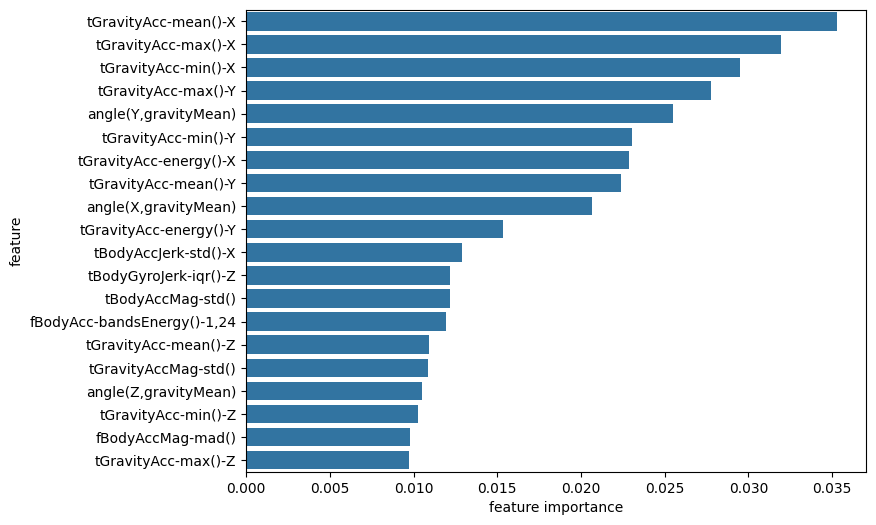

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# 1. 데이터 로드
train_data = pd.read_csv('./data/har_train.csv')
test_data = pd.read_csv('./data/har_test.csv')
# train_data.shape, test_data.shape

# 2. 데이터 분리
X_train = train_data.drop('Activity', axis=1)
X_test = test_data.drop('Activity', axis=1)
y_train = train_data['Activity']
y_test = test_data['Activity']

# 3. 레이블 인코딩 (Activity를 숫자로 변환)
# y_train.value_counts()
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 4. 데이터 정규화
# X_train.describe()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. RandomForestClassifier 모델 학습
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train_encoded)

# 6. 모델 예측
y_pred = rf_clf.predict(X_test_scaled)

# 7. 평가 (정확도) 
acc_score = accuracy_score(y_test_encoded, y_pred)
print(f"정확도: {acc_score}")

# 8. 중요도 상위 20개의 특성 시각화
feat_iptcs = rf_clf.feature_importances_
feat_names = X_train.columns

iptcs_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': feat_iptcs
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    y=iptcs_df['Feature'],
    x=iptcs_df['Importance']
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()

### GradientBoosting

#25.07.28

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

gb_clf = GradientBoostingClassifier(
    n_estimators=101, 
    learning_rate=0.01,
    max_depth=3
)

gb_clf.fit(X_train, y_train)

y_pred_train = gb_clf.predict(X_train)
y_pred_test = gb_clf.predict(X_test)

print(f'학습 정확도 : {accuracy_score(y_train, y_pred_train)}')
print(f'예측 정확도 : {accuracy_score(y_test, y_pred_test)}')

학습 정확도 : 0.9882629107981221
예측 정확도 : 0.958041958041958


### HistGradientBoosting

- 고성능 GradientBoosting 모델로 대규모 데이터셋 처리에 적합
- Histogram 기반으로 256개의 구간으로 나누러 처리 병합하는 방식
- 결측치가 있어도 전처리가 필요 없음
- LightGBM의 영향을 받아 만들어진 scikit-learn 의 모델

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1, 
    max_depth=3, 
    max_bins=255,   # 기본값 255개의 구간으로 나누어 처리. (1개는 결측치 전용)
    early_stopping=True,    # 반복 중 '일정 횟수' 이상 성능 향상이 없으면 학습 종료
    n_iter_no_change=5      # '일정 횟수' 지정하는 파라미터 (기본값 : 10)
)

hist_gb_clf.fit(X_train, y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)
print(f'학습 정확도 : {accuracy_score(y_train, y_pred_train)}')
print(f'예측 정확도 : {accuracy_score(y_test, y_pred_test)}')

학습 정확도 : 0.9953051643192489
예측 정확도 : 0.965034965034965


In [ ]:
# permutation_importance == 특성 중요도
from sklearn.inspection import permutation_importance

result = permutation_importance(
    hist_gb_clf, 
    X_train, 
    y_train, 
    n_repeats=5,       # 반복 횟수 지정 
    random_state=0
)

# importances_maen : 평균 중요도
# importances_std : 중요도 표준편차
# importances : 특성 중요도 

result.importances

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.00234742,  0.        ,  0.00234742,  0.00469484,  0.00938967],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00234742,  0.00234742,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00469484,  0.00469484,  0.00469484,  0.00704225,  0.00469484],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.00234742,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00469484,  0.        ,  0.0

### 회귀모델

sklearn.datasets.load_diabetes 데이터셋

- 당뇨병 환자의 진단 자료를 바탕으로 만들어진 회귀용 데이터셋
데이터셋 설명:

- 목적: 당뇨병 진행 정도(1년 후)를 예측
- 데이터 수: 442개의 샘플
- 특성 수: 10개의 특성 (10개의 입력 변수)
- 타겟: 연속형 값, 당뇨병의 1년 후 진행 상황을 나타냄

 특성 설명: 데이터셋의 각 특성(피처)은 환자의 다양한 생체 정보

1. age: 나이 (Age)
2. sex: 성별 (Sex)
3. bmi: 체질량 지수 (Body Mass Index)
4. bp: 평균 혈압 (Average Blood Pressure)
5. s1: 혈청 내 TC (Total Cholesterol)
6. s2: 혈청 내 LDL (Low-Density Lipoproteins)
7. s3: 혈청 내 HDL (High-Density Lipoproteins)
8. s4: 혈청 내 TCH (Total Cholesterol / HDL)
9. s5: 혈청 내 LTG (Log of Serum Triglycerides)
10. s6: 혈당 수치 (Blood Sugar Level)

데이터 구조:

- 입력 데이터 (data): (442, 10) 크기의 NumPy 배열
- 타겟 데이터 (target): (442,) 크기의 NumPy 배열로, 각 샘플의 타겟 값(연속형 값)을 포함

In [ ]:
from sklearn.datasets import load_diabetes

# 1. 데이터 로드 
data = load_diabetes()
#  df = pd.DataFrame(data.data, columns=data.feature_names)

# 2. 데이터 분리 
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 3. HistGrandientBoostingRegressor 모델 생성
hist_gb_reg = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=0,
    l2_regularization=0.5,
    min_samples_leaf=5
)

# 4~6. 학습 > 예측 > mse. r2_score 계산 
hist_gb_reg.fit(X_train, y_train)

y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)

print(f'학습 MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'평가 R2: {r2_score(y_test, y_pred_test)}')

학습 MSE: 1349.7927482181808
학습 R2: 0.7841531432486148
평가 MSE: 3692.3791002557186
평가 R2: 0.256230565040123


In [ ]:
# 교차 검증
from sklearn.model_selection import GridSearchCV    # 성능을 최적화 시켜주는 하이퍼파라미터를 찾아줌

In [ ]:
# 교차 검증
hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [255, 127]
}

grid_search = GridSearchCV(hist_gb_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# param_grid로 전달해준 하이퍼 파라미터 중 최고의 성능을 내는 하이퍼 파라미터 조합
grid_search.best_params_    

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'max_bins': 127,
 'max_depth': 1,
 'max_iter': 200,
 'min_samples_leaf': 20}

In [ ]:
# 최고의 성능을 내는 하이퍼 파라미터 조합으로 학습된 모델
best_hist_gb_reg = grid_search.best_estimator_

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'학습 R2: {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE: {mean_squared_error(y_test, y_pred_test)}')
print(f'평가 R2: {r2_score(y_test, y_pred_test)}')

학습 MSE: 2168.484353327469
학습 R2: 0.653235259858844
평가 MSE: 3455.1451971700467
평가 R2: 0.3040174583304508
